# PAGA

Running PAGA for pseudotime + trajectories. Python 3 (singlecell env).

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
from collections import Counter

### Cluster Config

In [18]:
cluster_config = pd.read_csv("../../figures_factory/configs/cluster.tsv", sep='\t')
cluster_config

,cluster,colour,description,new_cluster
0,1,#F4D5CD,Intermediate,12
1,2,#78A824,Pre-iPSC,15
2,3,#F01D35,Fibroblast-like,5
3,4,#E85F6D,Fibroblast-like,3
4,5,#B03743,Fibroblast,1
5,6,#7C2730,Fibroblast,2
6,7,#CF175A,Fibroblast-like,4
7,8,#CCCCCC,Doublets,17
8,9,#F7A6C2,Keratinocyte-like,6
9,10,#A6D854,Pre-iPSC,16


## Data

In [31]:
features = pd.read_csv("../20200206_pmat_snapATAC/sessions/20200520_n68916/features.9d.tsv", sep='\t')
features.head()

,sample_barcode,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,D0_AAACAACGACGATTAC,0.008273,-0.002722,0.003893,0.007244,-0.001470,0.005696,0.004268,-0.006692,-0.006634
1,D0_AAACAACGAGCGCACT,0.008111,-0.002691,0.004065,0.004544,0.000125,0.006694,0.005011,-0.002917,-0.004331
2,D0_AAACACGCTACGCCAC,0.007595,-0.002130,0.003780,0.005442,-0.000472,0.005300,0.002576,-0.002178,-0.001812
3,D0_AAACACGCTAGTACGG,0.008710,-0.002735,0.006064,0.006390,-0.003608,0.004332,0.008030,-0.004729,-0.001348
4,D0_AAACACGCTCCTCAAA,0.008703,-0.004403,0.004109,0.016435,0.006619,0.017768,0.003065,-0.000999,0.001036


In [35]:
metaData = pd.read_csv("../20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", sep='\t')
metaData.head()

,barcode,sample,umap1,umap2,cells,cluster
0,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC,5
1,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT,5
2,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC,5
3,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG,6
4,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA,5


In [93]:
adata = sc.AnnData(shape=(features.shape[0], 9))
adata

AnnData object with n_obs × n_vars = 68916 × 9

In [94]:
# feature representation
adata.obsm['X_diff'] = np.array(features.iloc[:, 1:])

# temporarily set X to X_diff also (downstream stuff doesn't work otherwise)
adata.X = adata.obsm['X_diff']

In [95]:
# use precomputed umap for consistency
adata.obsm['X_umap'] = np.array(metaData[["umap1", "umap2"]])

In [96]:
# new cluster labels
adata.obs["new_cluster"] = [str(x) for x in cluster_config.iloc[metaData['cluster']-1]["new_cluster"]]

In [97]:
adata

AnnData object with n_obs × n_vars = 68916 × 9
    obs: 'new_cluster'
    obsm: 'X_diff', 'X_umap'

In [98]:
# TEMP (Remove potential doublet cell states)
adata = adata[~adata.obs['new_cluster'].isin(['10', '17', '18'])]

In [99]:
# set back adata.X to None
# adata.X = None  # Doesn't work

/users/surag/anaconda3/envs/r36_cran/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'new_cluster' as categorical


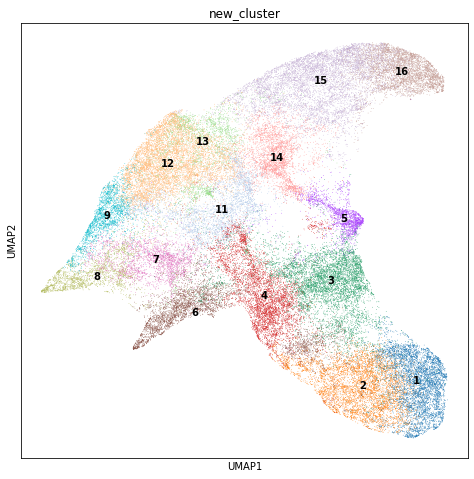

In [100]:
rcParams['figure.figsize'] = 8, 8

sc.pl.umap(adata, color="new_cluster", legend_loc='on data')

## Trajectory

In [101]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diff')

In [102]:
sc.tl.paga(adata, groups='new_cluster')

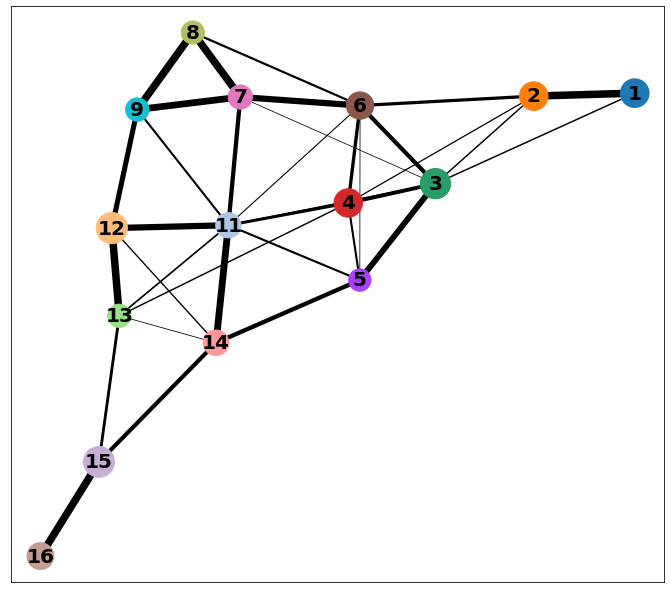

In [103]:
rcParams['figure.figsize'] = 10, 10

sc.pl.paga(adata, 
           threshold=.1, 
           fontsize=20, 
           node_size_scale=5,
#            solid_edges='connectivities_tree',
           show=True)

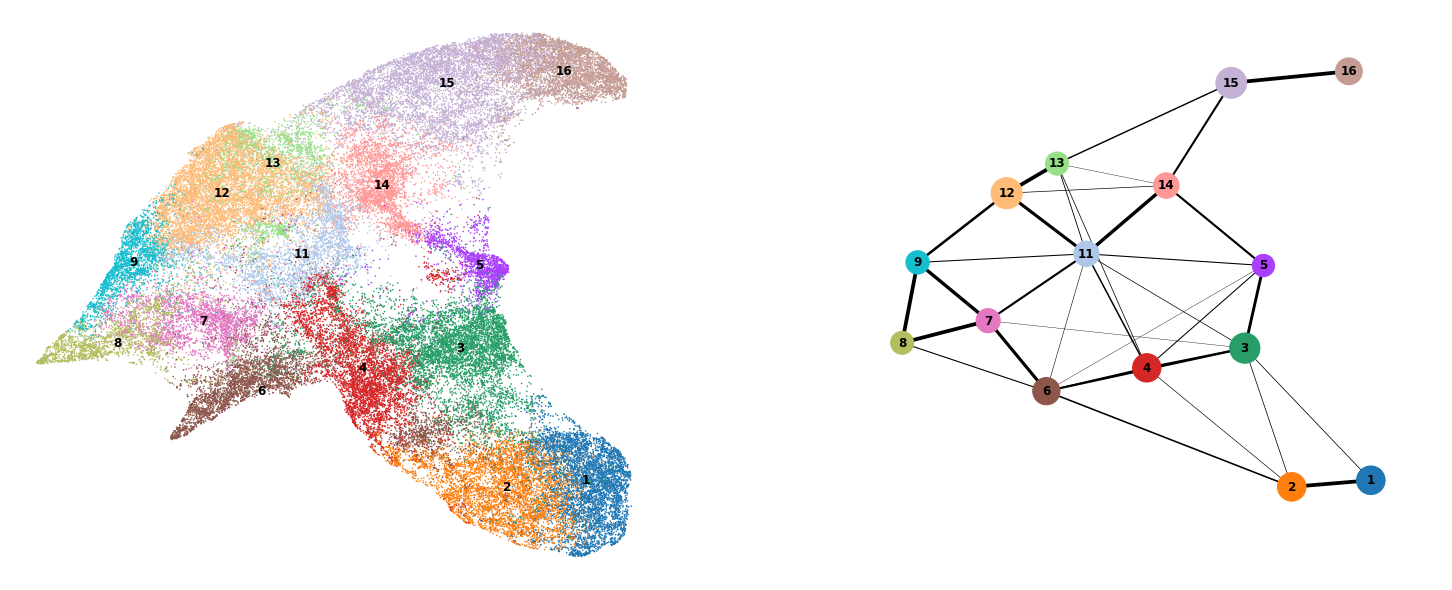

In [104]:
sc.pl.paga_compare(
    adata, threshold=0.1, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, frameon=False, edges=False, save=True,
    fontsize=20, 
    node_size_scale=5)

### Pseudotime

In [105]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['new_cluster']  == '1')[0]
adata.uns['iroot']

0

In [114]:
# re-running diffmaps though these features are diffmap outputs
# is required for dpt
sc.tl.diffmap(adata)

# can also set X_diffmap equal to X_diff
# but pseudotime is worse
# adata.obsm['X_diffmap'] = adata.obsm['X_diff']

In [118]:
sc.tl.dpt(adata)

# if using X_diff
# sc.tl.dpt(adata, n_dcs=9)

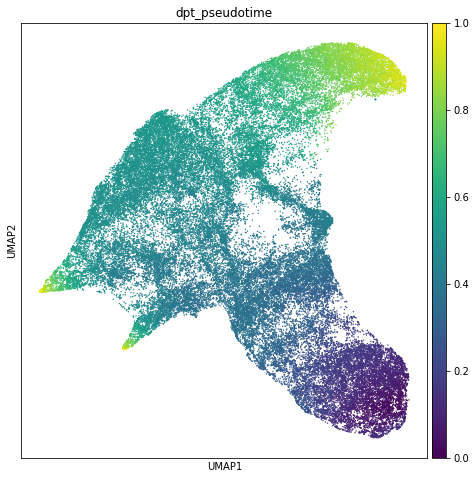

In [119]:
rcParams['figure.figsize'] = 8, 8

sc.pl.umap(adata, color=['dpt_pseudotime'], 
           size=8, 
           legend_loc='on data')

## Write Session Outputs

Currently unused.

In [217]:
# write umap coordinates, pseudotime, sample, cluster for downstream analysis
# metadata = pd.concat([features.iloc[:,:3], adata.obs[["leiden", "dpt_pseudotime"]]], axis=1)
# metadata = metadata.rename(columns={"x.sp.sample":"sample",
#                                    "leiden":"cluster"})
# metadata.head()

,sample,umap.1,umap.2,cluster,dpt_pseudotime
D0_AAACAACGACGATTAC,D0,6.545686,-7.701751,2,0.000000
D0_AAACAACGACTCACGG,D0,5.180663,-7.633298,2,0.037948
D0_AAACATGGAGACTCGC,D0,3.282927,-8.525186,1,0.107437
D0_AAACATGGATGGGCCT,D0,5.934059,-7.776163,2,0.015411
D0_AAACCGTACCTTTAGG,D0,2.642430,-8.592471,1,0.120589


In [210]:
SESH_NAME = "20200223_n{}".format(metadata.shape[0])
SESH_NAME

'20200223_n74838'

In [211]:
metadata.to_csv("./sessions/{}/metadata.tsv".format(SESH_NAME), sep='\t')

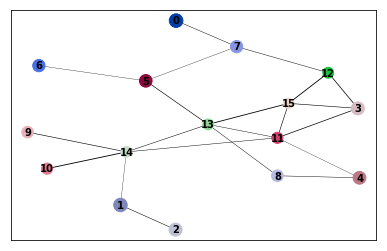

In [212]:
sc.pl.paga(adata, color=['leiden'], edge_width_scale=0.2, threshold=0.2, show=False)
pl.savefig("./sessions/{}/paga.pdf".format(SESH_NAME))